<a href="https://colab.research.google.com/github/nehaaggarwal6871/Image-Captioning/blob/master/ImageCaptioningUsingVGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import time
import progressbar
import matplotlib.pyplot as plt
import tensorflow as tf
# from keras.backend.tensorflow_backend import set_session
import keras
import sys, time, os, warnings 
import numpy as np
import pandas as pd 
from collections import Counter 
from keras.preprocessing.image import load_img, img_to_array
from nltk.tokenize import word_tokenize
warnings.filterwarnings("ignore")
from google.colab import drive
from glob import glob
import cv2
import pickle
from pickle import dump

In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:

!unzip gdrive/My\ Drive/ml_dataset/Image_captioning_Dataset.zip > /dev/null

In [5]:
image_path='/content/Flicker8k_Dataset/'
images = glob(image_path+ '*.jpg')
len(images)

8091

In [6]:
jpgs = os.listdir(image_path)
print("The number of jpg flies in Flicker30k: {}".format(len(jpgs)))

The number of jpg flies in Flicker30k: 8091


In [7]:
# images
# f=open("dir_Flickr_jpg.txt",'a')
# for i in images:
#   i=i.split('/')
#   f.write((i[3]+'\n'))

# f.close()

# f=open("dir_Flickr_jpg",'r')
# print(f.read())
# f.close()

dir_Flickr_jpg='/content/Flicker8k_Dataset/'

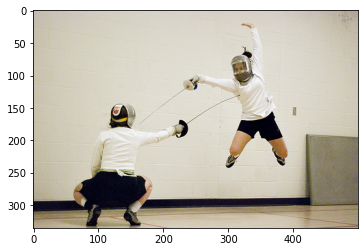

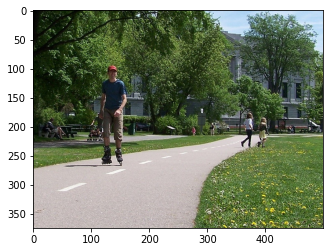

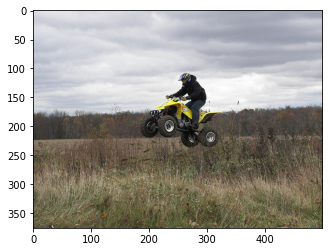

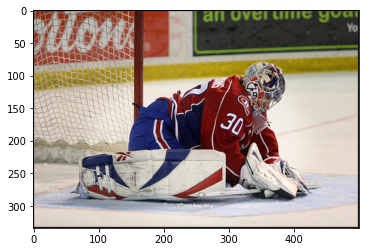

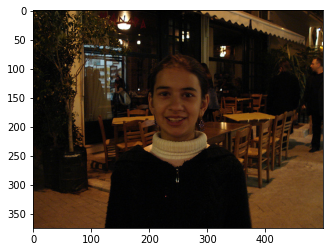

In [8]:
for i in range(5):
  plt.figure()
  image=cv2.imread(images[i])
  image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
  plt.imshow(image)

In [9]:
path= '/content/gdrive/MyDrive/ml_dataset/set_0.pkl'
mydataset=pickle.load(open(path, 'rb'))
mydataset



['318667317_108c402140.jpg#4\tA man in a black hoodie be hold a paper sign .',
 '2072574835_febf0c5fb9.jpg#4\tThree race dog be run out of the start gate on a track .',
 '3083016677_5782bc337c.jpg#4\tTwo motorcycle with two rider each .',
 '95734038_2ab5783da7.jpg#0\tA man on a bike nest to a river .',
 '241346146_f27759296d.jpg#1\tA football player try tackle another player who have the ball .',
 '3182405529_7692256746.jpg#2\tan old man with long gray hair and a long gray beard bike ride on the shore .',
 '3278777548_290b881018.jpg#1\tFour person walk on a bridge over a body of water .',
 '3621717946_d96f8a6012.jpg#3\tTwo swimmer be play a water sport with a yellow ball and a net .',
 '3542425197_2ef81c6051.jpg#1\tA woman in white lighting talk to a man light in green .',
 '3384742888_85230c34d5.jpg#3\tDog chew up ball while roll in grass',
 '514036362_5f2b9b7314.jpg#0\tA girl wear a black top be smile with a silver truck in the background .',
 '3331797838_b3e33dbe17.jpg#3\tTwo person

**Generating Data Frame**

In [10]:
datatxt = []
for line in mydataset:
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#")
    datatxt.append(w + [col[1].lower()])


# Framing the data
df_txt = pd.DataFrame(datatxt,columns=["filename","index","caption"])
print(df_txt.iloc[2])

# using numpy for data operations

uni_filenames = np.unique(df_txt.filename.values)
# print(uni_filenames)
print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:")
Counter(Counter(df_txt.filename.values).values())

filename               3083016677_5782bc337c.jpg
index                                          4
caption     two motorcycle with two rider each .
Name: 2, dtype: object
The number of unique file names : 8037
The distribution of the number of captions for each image:


Counter({4: 2239, 3: 2745, 2: 1744, 5: 753, 1: 556})

**Ploting the Images with its caption**

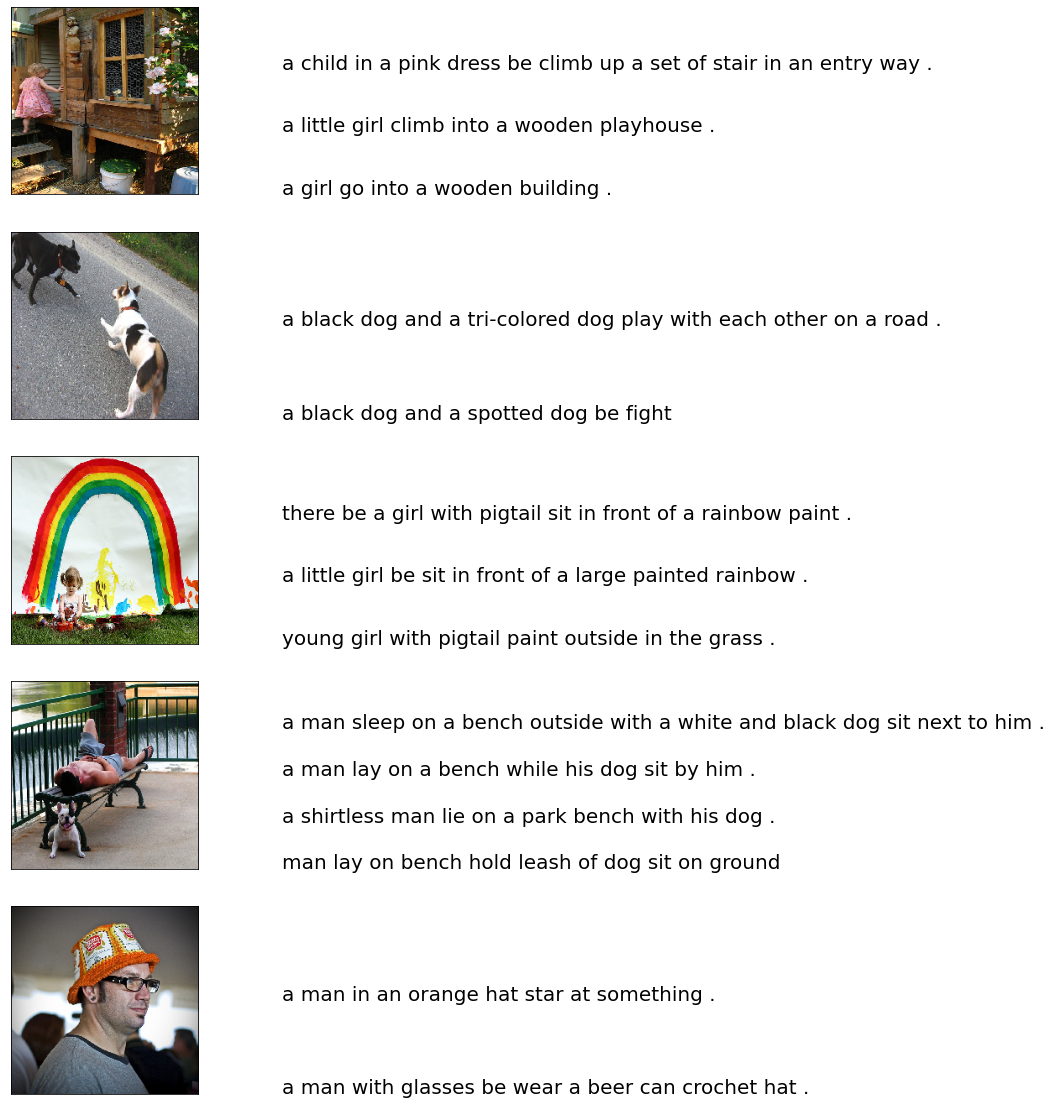

In [11]:

npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfilename in uni_filenames[:npic]:
    filename = dir_Flickr_jpg + '/' + jpgfilename
    captions = list(df_txt["caption"].loc[df_txt["filename"]==jpgfilename].values)
    # ÷resizing images
    image_load = load_img(filename, target_size=target_size)
    
    
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

**Creating Vocabulary**

In [12]:
def df_word(df_txt):
    vocabulary = []
    for i in range(len(df_txt)):
        temp=df_txt.iloc[i,2]
        # print(temp)
        vocabulary.extend(temp.split())
        
    # print(vocabulary)
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    # count words in a vocabulary
    ct = Counter(vocabulary)
    dfword = pd.DataFrame({"word":list(ct.keys()),"count":list(ct.values())})
    # Sort according to count
    dfword = dfword.sort_values("count",ascending=False)
    # print(dfword)
    dfword = dfword.reset_index()[["word","count"]]
    # print(dfword)
    return(dfword)
dfword = df_word(df_txt)
dfword.head(13)

Vocabulary Size: 5560


,word,count
0,a,42840
1,.,22578
2,in,11912
3,be,8210
4,on,6601
5,the,6557
6,dog,6266
7,and,5428
8,man,5175
9,with,4820


# **50 Top most frequently words and 50 least frequently words**

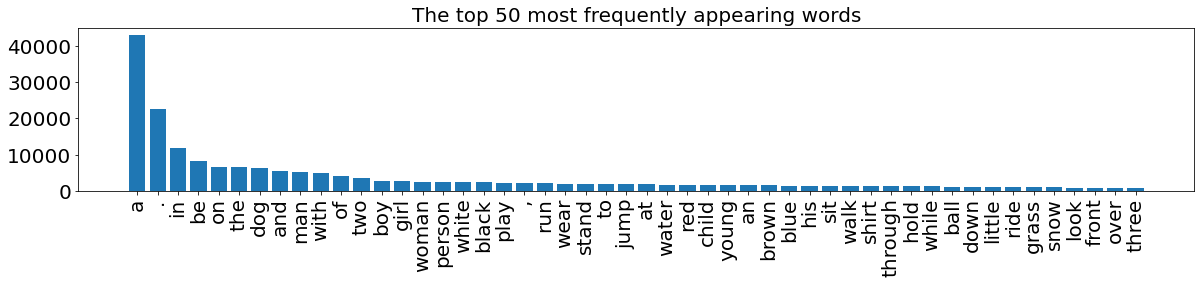

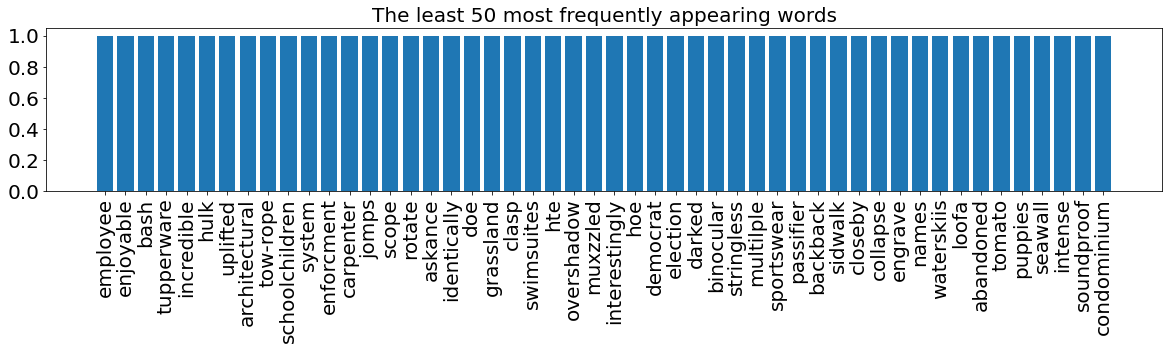

In [13]:
topn = 50

def plthist(dfsub, title="The top 50 most frequently appearing words"):
    plt.figure(figsize=(20,3))
    plt.bar(dfsub.index,dfsub["count"])
    plt.yticks(fontsize=20)
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()

plthist(dfword.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfword.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

# Removing -
- punctuation
- single characters
- numeric characters

In [14]:
import string
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(str.maketrans('','',string.punctuation))
    return(text_no_punctuation)

def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)

def remove_numeric(text,printTF=False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("    {:10} : {:}".format(word,isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)

**Cleaning data**

In [15]:
def text_clean(text_original):
    # print(text_original)
    text = remove_punctuation(text_original)
    
    text = remove_single_character(text)
    # print(text)
    text = remove_numeric(text)
    return(text)

with progressbar.ProgressBar(max_value=len(df_txt.caption.values)) as bar:
    for i, caption in enumerate(df_txt.caption.values):
        newcaption = text_clean(caption)
        df_txt["caption"].iloc[i] = newcaption
        bar.update(i)

100% (25000 of 25000) |##################| Elapsed Time: 0:00:09 Time:  0:00:09


**Frequent words in cleanse data**

Vocabulary Size: 5490


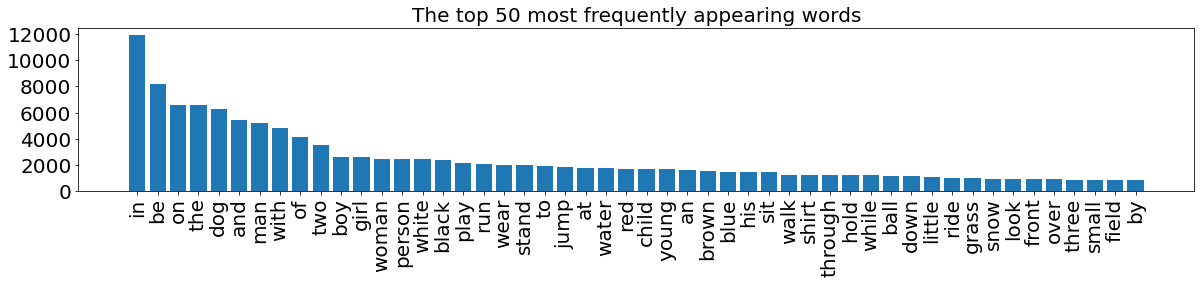

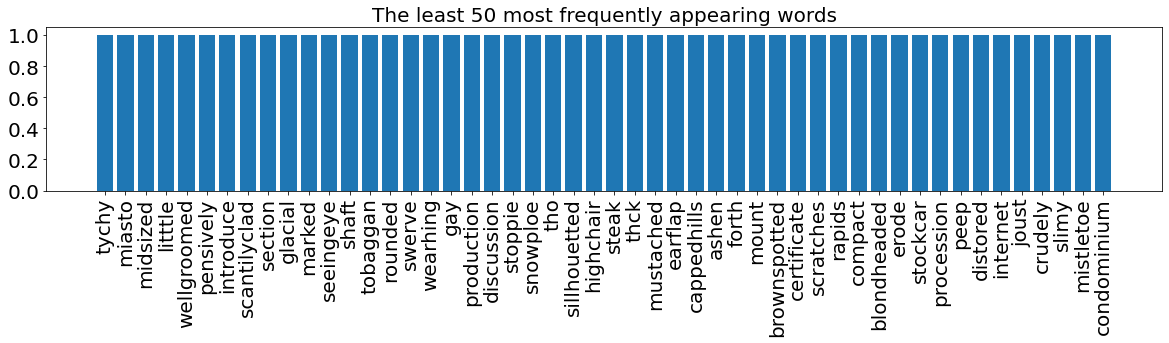

In [16]:
dfword = df_word(df_txt)
plthist(dfword.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfword.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

In [17]:
from copy import copy
def add_start_end_seq_token(captions):
    caps = []
    for txt in captions:
        txt = 'startseq ' + txt + ' endseq'
        caps.append(txt)
    return(caps)
df_txt0 = copy(df_txt)
df_txt0["caption"] = add_start_end_seq_token(df_txt["caption"])
print(df_txt0.head(5))
del df_txt

                    filename index  \
0   318667317_108c402140.jpg     4   
1  2072574835_febf0c5fb9.jpg     4   
2  3083016677_5782bc337c.jpg     4   
3    95734038_2ab5783da7.jpg     0   
4   241346146_f27759296d.jpg     1   

                                             caption  
0  startseq  man in black hoodie be hold paper si...  
1  startseq  three race dog be run out of the sta...  
2  startseq  two motorcycle with two rider each e...  
3         startseq  man on bike nest to river endseq  
4  startseq  football player try tackle another p...  


# Creating Model

In [18]:
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16

modelvgg = VGG16(include_top=True,weights='imagenet')
## load the locally saved weights 
# modelvgg.load_weights("../input/vgg16-weights-image-captioning/vgg16_weights_tf_dim_ordering_tf_kernels.h5")
modelvgg.summary()

553476096/553467096 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [19]:
from keras.models import Model
modelvgg.layers.pop()
modelvgg = Model(inputs=modelvgg.inputs, outputs=modelvgg.get_layer('fc2').output)
## show the deep learning model
modelvgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from collections import OrderedDict

images = OrderedDict()
npix = 224
target_size = (npix,npix,3)
with progressbar.ProgressBar(max_value=len(jpgs)) as bar:
    for i,name in enumerate(jpgs):
        # load an image from file
        filename = dir_Flickr_jpg + '/' + name
        image = load_img(filename, target_size=target_size)
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        nimage = preprocess_input(image)
        y_pred = modelvgg.predict(nimage.reshape( (1,) + nimage.shape[:3]))
        images[name] = y_pred.flatten()
        bar.update(i)
    print(i,filename)


  4% (367 of 8091) |                     | Elapsed Time: 0:03:43 ETA:   1:16:03

In [ ]:
dimages, keepindex = [],[]
nd=(df_txt0["index"].values)
b = [(int(i)==0) for i in nd]
#for i in nd:
 #   print(int(i)==0)
#df_txt0 = df_txt0.loc[b,: ]
df_txt0 = df_txt0.loc[df_txt0["index"].values == "0",: ]

for i, fnm in enumerate(df_txt0.filename):
    if fnm in images.keys():
        dimages.append(images[fnm])
        keepindex.append(i)
        
fnames = df_txt0["filename"].iloc[keepindex].values
dcaptions = df_txt0["caption"].iloc[keepindex].values
dimages = np.array(dimages)
print(df_txt0["index"][:5])

In [ ]:
from keras.preprocessing.text import Tokenizer
## the maximum number of words in dictionary
count_words=22000
#nb_words = 31782
tokenizer = Tokenizer(num_words=8000)
tokenizer.fit_on_texts(dcaptions)
vocab_size = len(tokenizer.word_index) + 1
print("vocabulary size : {}".format(vocab_size))
dtexts = tokenizer.texts_to_sequences(dcaptions)
print(dtexts[:5])


In [ ]:
prop_test, prop_val = 0.2, 0.2 

N = len(dtexts)
Ntest, Nval = int(N*prop_test), int(N*prop_val)

def split_test_val_train(dtexts,Ntest,Nval):
    return(dtexts[:Ntest], 
           dtexts[Ntest:Ntest+Nval],  
           dtexts[Ntest+Nval:])

dt_test,  dt_val, dt_train   = split_test_val_train(dtexts,Ntest,Nval)
di_test,  di_val, di_train   = split_test_val_train(dimages,Ntest,Nval)
fnm_test,fnm_val, fnm_train  = split_test_val_train(fnames,Ntest,Nval)

In [ ]:
maxlen = np.max([len(text) for text in dtexts])


In [100]:
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def preprocessing(dtexts,dimages):
    N = len(dtexts)
    print("# captions/images = {}".format(N))

    assert(N==len(dimages))
    Xtext, Ximage, ytext = [],[],[]
    for text,image in zip(dtexts,dimages):

        for i in range(1,len(text)):
            in_text, out_text = text[:i], text[i]
            in_text = pad_sequences([in_text],maxlen=maxlen).flatten()
            out_text = to_categorical(out_text,num_classes = vocab_size)

            Xtext.append(in_text)
            Ximage.append(image)
            ytext.append(out_text)

    Xtext  = np.array(Xtext)
    Ximage = np.array(Ximage)
    ytext  = np.array(ytext)
    print(" {} {} {}".format(Xtext.shape,Ximage.shape,ytext.shape))
    return(Xtext,Ximage,ytext)


Xtext_train, Ximage_train, ytext_train = preprocessing(dt_train,di_train)
Xtext_val,   Ximage_val,   ytext_val   = preprocessing(dt_val,di_val)
# pre-processing is not necessary for testing data
#Xtext_test,  Ximage_test,  ytext_test  = preprocessing(dt_test,di_test)

# captions/images = 3010
 (30400, 28) (30400, 4096) (30400, 2785)
# captions/images = 1002
 (10105, 28) (10105, 4096) (10105, 2785)


In [101]:
from keras import layers
print(vocab_size)
## image feature

dim_embedding = 64

input_image = layers.Input(shape=(Ximage_train.shape[1],))
fimage = layers.Dense(256,activation='relu',name="ImageFeature")(input_image)
## sequence model
input_txt = layers.Input(shape=(maxlen,))
ftxt = layers.Embedding(vocab_size,dim_embedding, mask_zero=True)(input_txt)
ftxt = layers.LSTM(256,name="CaptionFeature")(ftxt)
## combined model for decoder
decoder = layers.add([ftxt,fimage])
decoder = layers.Dense(256,activation='relu')(decoder)
output = layers.Dense(vocab_size,activation='softmax')(decoder)
model = models.Model(inputs=[input_image, input_txt],outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam')

print(model.summary())

2785
Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 28)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 28, 64)       178240      ['input_6[0][0]']                
                                                                                                  
 input_5 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 CaptionFeature (LSTM)          (None, 256)          328704      ['embedding[0][0]']              
                                                                                       

In [102]:
start = time.time()
#checkpoint_path = "training_1/cp.ckpt"
#checkpoint_dir = os.path.dirname(checkpoint_path)

# Create checkpoint callback
#cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
 #                                                save_weights_only=True,
  #                                               verbose=2)

hist = model.fit([Ximage_train, Xtext_train], ytext_train, 
                  epochs=7, verbose=2, 
                  batch_size=64,
                  validation_data=([Ximage_val, Xtext_val], ytext_val))
                #callbacks = [cp_callback])
end = time.time()
print("TIME TOOK {:3.2f}MIN".format((end - start )/60))

Epoch 1/7
475/475 - 100s - loss: 5.2346 - val_loss: 4.7982 - 100s/epoch - 211ms/step
Epoch 2/7
475/475 - 97s - loss: 4.2986 - val_loss: 4.4653 - 97s/epoch - 204ms/step
Epoch 3/7
475/475 - 98s - loss: 3.7842 - val_loss: 4.3752 - 98s/epoch - 205ms/step
Epoch 4/7
475/475 - 93s - loss: 3.4312 - val_loss: 4.4184 - 93s/epoch - 196ms/step
Epoch 5/7
475/475 - 94s - loss: 3.1248 - val_loss: 4.5544 - 94s/epoch - 197ms/step
Epoch 6/7
475/475 - 93s - loss: 2.8415 - val_loss: 4.7667 - 93s/epoch - 197ms/step
Epoch 7/7
475/475 - 94s - loss: 2.5642 - val_loss: 5.0290 - 94s/epoch - 198ms/step
TIME TOOK 11.15MIN


In [103]:
print(Ximage_train.shape,Xtext_train.shape,ytext_train.shape)


(30400, 4096) (30400, 28) (30400, 2785)


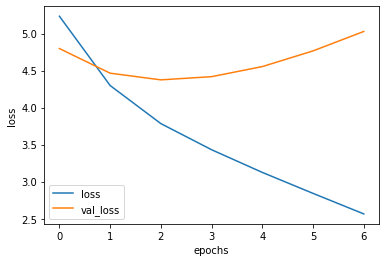

In [104]:
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

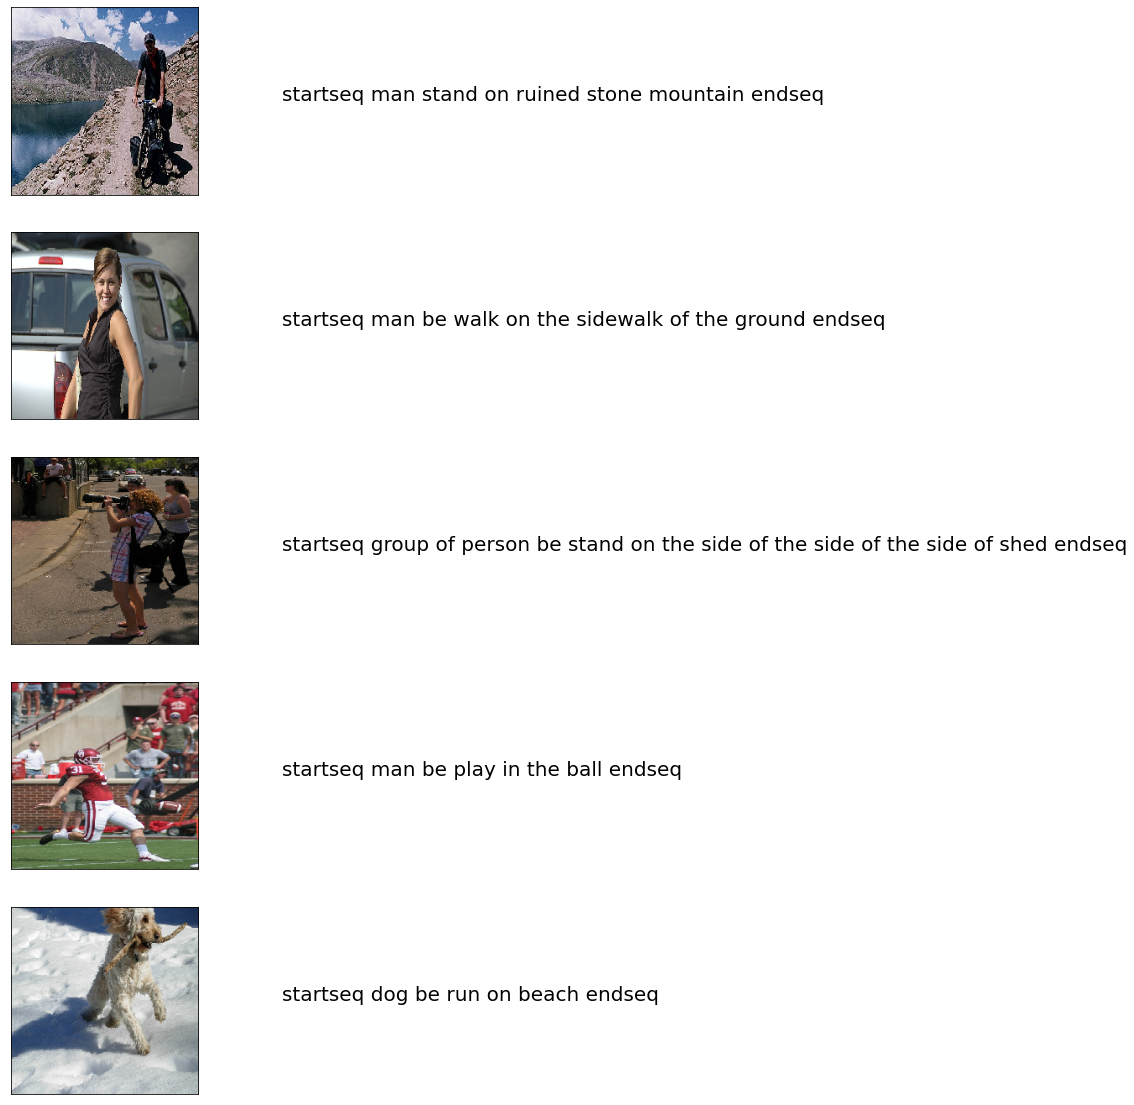

In [105]:
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])
def predict_caption(image):
    '''
    image.shape = (1,4462)
    '''

    in_text = 'startseq'

    for iword in range(maxlen):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],maxlen)
        yhat = model.predict([image,sequence],verbose=0)
        yhat = np.argmax(yhat)
        newword = index_word[yhat]
        in_text += " " + newword
        if newword == "endseq":
            break
    return(in_text)



npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm, image_feature in zip(fnm_test[:npic],di_test[:npic]):
    ## images 
    filename = dir_Flickr_jpg + '/' + jpgfnm
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.text(0,0.5,caption,fontsize=20)
    count += 1

plt.show()

In [1]:
from nltk.translate.bleu_score import sentence_bleu
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])


nkeep = 5
pred_good, pred_bad, bleus = [], [], [] 
count = 0 
for jpgfnm, image_feature, tokenized_text in zip(fnm_test,di_test,dt_test):
    count += 1
    if count % 200 == 0:
        print("  {:4.2f}% is done..".format(100*count/float(len(fnm_test))))
    
    caption_true = [ index_word[i] for i in tokenized_text ]     
    caption_true = caption_true[1:-1] ## remove startreg, and endreg
    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    caption = caption.split()
    caption = caption[1:-1]## remove startreg, and endreg
    
    bleu = sentence_bleu([caption_true],caption)
    bleus.append(bleu)
    if bleu > 0.7 and len(pred_good) < nkeep:
        pred_good.append((bleu,jpgfnm,caption_true,caption))
    elif bleu < 0.3 and len(pred_bad) < nkeep:
        pred_bad.append((bleu,jpgfnm,caption_true,caption))

NameError: ignored

In [ ]:
def plot_images(pred_bad):
    def create_str(caption_true):
        strue = ""
        for s in caption_true:
            strue += " " + s
        return(strue)
    npix = 224
    target_size = (npix,npix,3)    
    count = 1
    fig = plt.figure(figsize=(10,20))
    npic = len(pred_bad)
    for pb in pred_bad:
        bleu,jpgfnm,caption_true,caption = pb
        ## images 
        filename = dir_Flickr_jpg + '/' + jpgfnm
        image_load = load_img(filename, target_size=target_size)
        ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        caption_true = create_str(caption_true)
        caption = create_str(caption)
        
        ax = fig.add_subplot(npic,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.text(0,0.7,"true:" + caption_true,fontsize=20)
        ax.text(0,0.4,"pred:" + caption,fontsize=20)
        ax.text(0,0.1,"BLEU: {}".format(bleu),fontsize=20)
        count += 1
    plt.show()

print("Bad Caption")
plot_images(pred_bad)
print("Good Caption")
plot_images(pred_good)